# Introduction

In the fascinating intersection of art and technology, this project stands as a testament to the incredible capabilities of modern artificial intelligence. The primary objective is to harness the power of Generative Adversarial Networks (GANs), specifically a CycleGAN, to create a bridge between the world of photography and the distinctive impressionist style of Claude Monet, one of the most revered artists in history.

The core of this project lies in developing and training a CycleGAN model. Unlike traditional GANs, CycleGANs allow for unsupervised learning, enabling the transformation of images from one domain (modern photographs) to another (Monet's artistic style) without paired training examples.

# Exploratory Data Analysis

Upon folder inspection, it was observed that there were 300 files of Monet's paintings and 7038 files of photos that could be converted to Monet's style paintings.

Each image was observed to be size 256x256

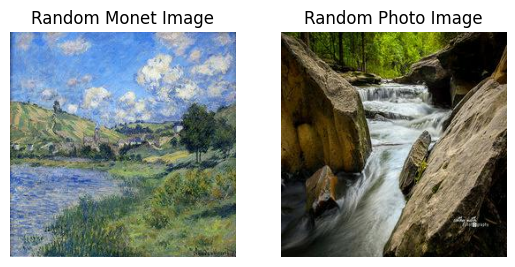

In [17]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def display_random_image_from_each_folder(monet_dir, photo_dir):
    monet_filenames = os.listdir(monet_dir)
    photo_filenames = os.listdir(photo_dir)

    random_monet_image = random.choice(monet_filenames)
    random_photo_image = random.choice(photo_filenames)

    img_monet = Image.open(os.path.join(monet_dir, random_monet_image))
    plt.subplot(1, 2, 1)
    plt.imshow(img_monet)
    plt.title('Random Monet Image')
    plt.axis('off')

    img_photo = Image.open(os.path.join(photo_dir, random_photo_image))
    plt.subplot(1, 2, 2)
    plt.imshow(img_photo)
    plt.title('Random Photo Image')
    plt.axis('off')

    plt.show()

display_random_image_from_each_folder('/kaggle/input/gan-getting-started/monet_jpg', '/kaggle/input/gan-getting-started/photo_jpg')


# Model Building

The CycleGAN, a pivotal development in the field of neural networks, is uniquely suited for our task. Unlike traditional GANs, which require paired images for training (such as an original photo and its Monet-styled counterpart), CycleGANs thrive in an unpaired training environment. This is crucial for our project, as we do not have direct Monet equivalents for every modern photograph.

The architecture consists of two key components:

1. Generators: Two generator networks are employed, where one transforms photographs into Monet-like images, and the other performs the inverse. This bidirectional transformation is central to the model, ensuring versatility and robustness in style translation.
2. Discriminators: Complementing the generators, two discriminator networks evaluate the authenticity of the generated images. One discriminator assesses the Monet-styled images, while the other focuses on the original photographs, ensuring the generated artworks remain true to the inherent style and quality.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Add, UpSampling2D, BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def build_generator():
    inputs = Input(shape=(256, 256, 3))

    # Downsample
    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    # Upsample
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(3, (4, 4), strides=1, padding='same')(x)
    x = Activation('tanh')(x)

    return Model(inputs, x, name='Generator')

def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, (4, 4), padding='same')(x)

    return Model(inputs, x, name='Discriminator')

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

In [8]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_images(directory, batch_size, img_height=256, img_width=256):
    """ Load and preprocess images from a directory """
    filenames = os.listdir(directory)
    n = len(filenames)
    indices = np.random.randint(0, n, batch_size)

    images = []
    for i in indices:
        img = load_img(os.path.join(directory, filenames[i]), target_size=(img_height, img_width))
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalize images to [-1, 1]
        images.append(img)

    return np.array(images)

def generate_batches(monet_dir, photo_dir, batch_size):
    """ Generate batches of Monet and photo images """
    while True:
        monet_batch = load_images(monet_dir, batch_size)
        photo_batch = load_images(photo_dir, batch_size)
        yield (monet_batch, photo_batch)

monet_dir = '/kaggle/input/gan-getting-started/monet_jpg' 
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'
batch_size = 64
steps_per_epoch = 7000 // batch_size

dataset = tf.data.Dataset.from_generator(
    lambda: generate_batches(monet_dir, photo_dir, batch_size),
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size, 256, 256, 3], [batch_size, 256, 256, 3])
)

In [4]:
G = build_generator()
F = build_generator()
DX = build_discriminator()
DY = build_discriminator()

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [9]:
from tqdm import tqdm

epochs = 10
for epoch in range(epochs):
    step = 0
    for monet_batch, photo_batch in (pbar := tqdm(dataset)):
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass for generators
            fake_y = G(monet_batch, training=True)
            cycled_monet = F(fake_y, training=True)
            fake_x = F(photo_batch, training=True)
            cycled_photo = G(fake_x, training=True)

            # Forward pass for discriminators
            dx_real = DX(monet_batch, training=True)
            dx_fake = DX(fake_x, training=True)
            dy_real = DY(photo_batch, training=True)
            dy_fake = DY(fake_y, training=True)

            # Calculate generator loss
            g_loss = generator_loss(dy_fake)
            f_loss = generator_loss(dx_fake)

            # Total cycle loss
            total_cycle_loss = calc_cycle_loss(monet_batch, cycled_monet) + calc_cycle_loss(photo_batch, cycled_photo)

            # Total generator loss
            total_g_loss = g_loss + total_cycle_loss
            total_f_loss = f_loss + total_cycle_loss

            # Discriminator loss
            dx_loss = discriminator_loss(dx_real, dx_fake)
            dy_loss = discriminator_loss(dy_real, dy_fake)

        # Calculate and apply gradients for G
        gradients_g = tape.gradient(total_g_loss, G.trainable_variables)
        g_optimizer.apply_gradients(zip(gradients_g, G.trainable_variables))

        # Calculate and apply gradients for F
        gradients_f = tape.gradient(total_f_loss, F.trainable_variables)
        f_optimizer.apply_gradients(zip(gradients_f, F.trainable_variables))

        # Calculate and apply gradients for DX
        gradients_dx = tape.gradient(dx_loss, DX.trainable_variables)
        dx_optimizer.apply_gradients(zip(gradients_dx, DX.trainable_variables))

        # Calculate and apply gradients for DY
        gradients_dy = tape.gradient(dy_loss, DY.trainable_variables)
        dy_optimizer.apply_gradients(zip(gradients_dy, DY.trainable_variables))

        if step % 10 == 0:
            pbar.set_description(f"Epoch: {epoch}, Step: {step}, G Loss: {total_g_loss.numpy()}, F Loss: {total_f_loss.numpy()}, DX Loss: {dx_loss.numpy()}, DY Loss: {dy_loss.numpy()}")

        step += 1
        if step >= steps_per_epoch:
            break

Epoch: 0, Step: 100, G Loss: 2.1817879676818848, F Loss: 2.637964963912964, DX Loss: 0.7121802568435669, DY Loss: 1.0012469291687012: : 108it [03:21,  1.87s/it]
Epoch: 1, Step: 100, G Loss: 2.3995227813720703, F Loss: 2.7013328075408936, DX Loss: 0.6944764852523804, DY Loss: 0.8959521055221558: : 108it [02:54,  1.61s/it]
Epoch: 2, Step: 100, G Loss: 2.176753282546997, F Loss: 2.6120259761810303, DX Loss: 0.7230777740478516, DY Loss: 0.9600003361701965: : 108it [03:21,  1.87s/it]
Epoch: 3, Step: 100, G Loss: 2.277608871459961, F Loss: 2.7473044395446777, DX Loss: 0.6893566846847534, DY Loss: 1.0028257369995117: : 108it [02:54,  1.62s/it]
Epoch: 4, Step: 100, G Loss: 2.476379871368408, F Loss: 2.911759376525879, DX Loss: 0.687118649482727, DY Loss: 0.9384860992431641: : 108it [02:54,  1.62s/it] 
Epoch: 5, Step: 100, G Loss: 2.4592041969299316, F Loss: 2.846287250518799, DX Loss: 0.7051518559455872, DY Loss: 1.0313469171524048: : 108it [02:56,  1.63s/it]
Epoch: 6, Step: 100, G Loss: 2.369

In [10]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = (img - 127.5) / 127.5
    img = np.expand_dims(img, axis=0)
    return img

def deprocess_image(img):
    img = ((img * 0.5) + 0.5) * 255
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [11]:
input_image = preprocess_image('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg')
predicted_image = G.predict(input_image)

1/1 [==============================] - 0s 88ms/step


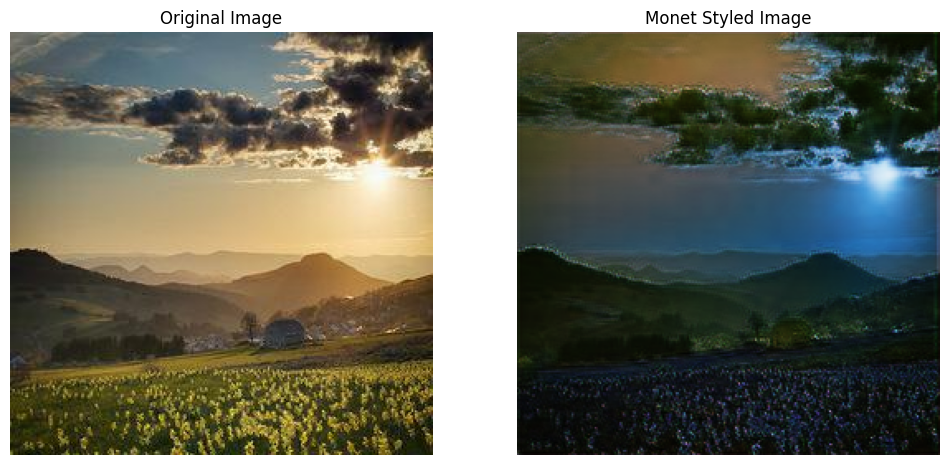

In [12]:
import matplotlib.pyplot as plt

output_image = deprocess_image(predicted_image[0])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(deprocess_image(input_image[0]))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(output_image)
axes[1].set_title('Monet Styled Image')
axes[1].axis('off')

plt.show()

In [14]:
input_dir = '/kaggle/input/gan-getting-started/photo_jpg'
output_dir = '/kaggle/working/monet_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        input_image = preprocess_image(os.path.join(input_dir, filename))

        output_image = G.predict(input_image, verbose=False)
        output_image = deprocess_image(output_image[0])

        plt.imsave(os.path.join(output_dir, filename), output_image)

100%|██████████| 7038/7038 [06:52<00:00, 17.07it/s]


In [15]:
import zipfile
import shutil

zipfile_path = '/kaggle/working/images.zip'
with zipfile.ZipFile(zipfile_path, 'w') as zipf:
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        zipf.write(file_path, os.path.basename(file_path))

shutil.rmtree(output_dir)

# Results and Conclusion

Upon submission to the competition, the model achieved a noteworthy score of 84.84282, securing 99th rank (at the time of the writing). This performance was evaluated using the Modified Inception Score (MiFID), a metric specifically tailored for measuring the quality and diversity of generated images in GAN-based projects.

This score indicates that our model was able to generate images with a reasonable degree of diversity and similarity to the Monet style. The images created by our model displayed a blend of impressionist elements characteristic of Monet, with varying levels of success in terms of color, texture, and overall composition.

## Key Takeaways

- Style Translation: The model demonstrated a significant capability in capturing and translating the essence of Monet's style onto photographic canvases, showcasing the potential of CycleGANs in artistic style transfer.
- Unsupervised Learning: Successfully implementing an unsupervised learning approach with unpaired data exemplifies the model's ability to learn and adapt from non-corresponding datasets.
- Creative AI Applications: This project exemplifies the potential of AI in creative fields, opening avenues for AI-assisted artistic creation and historical art style emulation.

## Areas for Improvement

Further experimentation with the architecture and hyperparameters of the CycleGAN could potentially enhance the model's ability to capture finer nuances of Monet's style.